## Problem statement

The objective of this project is to build a binary classification model to predict whether a material is a metal or a non-metal. I am using the matbench_expt_is_metal dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org), which consists of approximately 4,921 samples. Each entry includes:

* Input: A chemical composition (e.g., "Fe2O3").

* Target: A boolean label (True for metal, False for non-metal).


The model will be evaluated using the ROC-AUC score (Area Under the Receiver Operating Characteristic Curve). According to the official MatBench leaderboard, the best reported benchmark score for the matbench_expt_is_metal task is approximately 0.9520.

This project aims to investigate whether accurate predictions can be achieved using only composition-only features, in combination with Random Forest and XGBoost models.

## Data preparation

In [ ]:
# Installation of libraries (Datasets and featurisation )
%pip install matminer --quiet

In [ ]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

CID = 6046262

# Detailed on https://hackingmaterials.lbl.gov/matminer/dataset_summary.html
# Uncomment the info line for your assigned challenge code 

  # A 
#info = get_all_dataset_info("matbench_dielectric")

  # B 
#info = get_all_dataset_info("matbench_expt_gap")

  # C 
info = get_all_dataset_info("matbench_expt_is_metal")

  # D 
#info = get_all_dataset_info("matbench_glass")

  # E 
#info = get_all_dataset_info("matbench_steels")

# Check the dataset information
print(info)

Dataset: matbench_expt_is_metal
Description: Matbench v0.1 test dataset for classifying metallicity from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, ensuring no conflicting reports were entered for any compositions (i.e., no reported compositions were both metal and nonmetal). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	is_metal: Target variable. 1 if is a metal, 0 if nonmetal.
Num Entries: 4921
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 
 https//:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexander\nand Wang, Qi\nand Ganose, Alex\nand Dopp, Daniel\nand Jain, Anubhav},\ntitle={Benc

     chemical_composition  is_metal
0                Ag(AuS)2      True
1              Ag(W3Br7)2      True
2        Ag0.5Ge1Pb1.75S4     False
3       Ag0.5Ge1Pb1.75Se4     False
4                  Ag2BBr      True
...                   ...       ...
4916               ZrTaN3     False
4917                 ZrTe      True
4918               ZrTi2O      True
4919               ZrTiF6      True
4920                 ZrW2      True

[4921 rows x 2 columns]
Number of metallic samples: 2451
Number of non-metallic samples: 2470


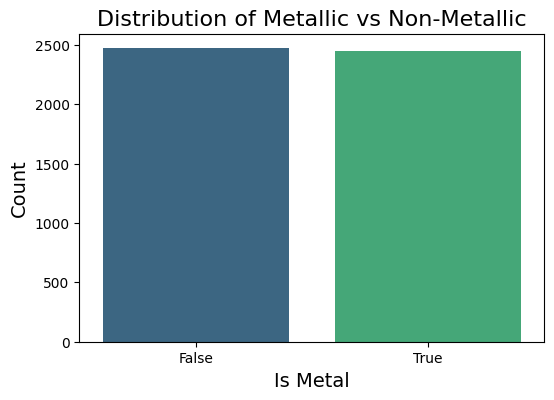

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset into a pandas DataFrame
df = load_dataset("matbench_expt_is_metal")
df = df.rename(columns={"composition": "chemical_composition"})
print(df)

# Basic statistics
print(f"Number of metallic samples: {sum(df['is_metal'] == True)}")
print(f"Number of non-metallic samples: {sum(df['is_metal'] == False)}")

# Check distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_metal', data=df, hue='is_metal', palette='viridis',legend=False)
plt.title('Distribution of Metallic vs Non-Metallic', fontsize=16)
plt.xlabel('Is Metal', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [5]:
# Convert chemical formula strings into Composition objects
from matminer.featurizers.conversions import StrToComposition
stc = StrToComposition()
df = stc.featurize_dataframe(df, "chemical_composition", pbar=False)

# Apply the ElementProperty featuriser to calculate features based on the elements.
from matminer.featurizers.composition.composite import ElementProperty
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition', pbar=False)

# Print the shape of the DataFrame
print(df.shape)
df.head()


(4921, 135)


,chemical_composition,is_metal,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Ag(AuS)2,True,"(Ag, Au, S)",16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,163.000000,74.400000,70.0
1,Ag(W3Br7)2,True,"(Ag, W, Br)",35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,118.809524,73.079365,64.0
2,Ag0.5Ge1Pb1.75S4,False,"(Ag, Ge, Pb, S)",16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,139.482759,76.670630,70.0
3,Ag0.5Ge1Pb1.75Se4,False,"(Ag, Ge, Pb, Se)",32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,...,0.0,0.0,0.0,0.0,14.0,225.0,211.0,108.586207,104.370987,14.0
4,Ag2BBr,True,"(Ag, B, Br)",5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,...,0.0,0.0,0.0,0.0,64.0,225.0,161.0,170.000000,55.000000,225.0


In [6]:
# Check for missing values
df.isna().sum()

chemical_composition                   0
is_metal                               0
composition                            0
MagpieData minimum Number              0
MagpieData maximum Number              0
                                      ..
MagpieData maximum SpaceGroupNumber    0
MagpieData range SpaceGroupNumber      0
MagpieData mean SpaceGroupNumber       0
MagpieData avg_dev SpaceGroupNumber    0
MagpieData mode SpaceGroupNumber       0
Length: 135, dtype: int64

In [7]:
# Remove rows containing NaN
df = df.dropna()

# Separate features and target
X = df.drop(columns=['chemical_composition', 'composition', 'is_metal'])
y = df['is_metal']

print(f"Final number of features: {X.shape[1]}")

Final number of features: 132


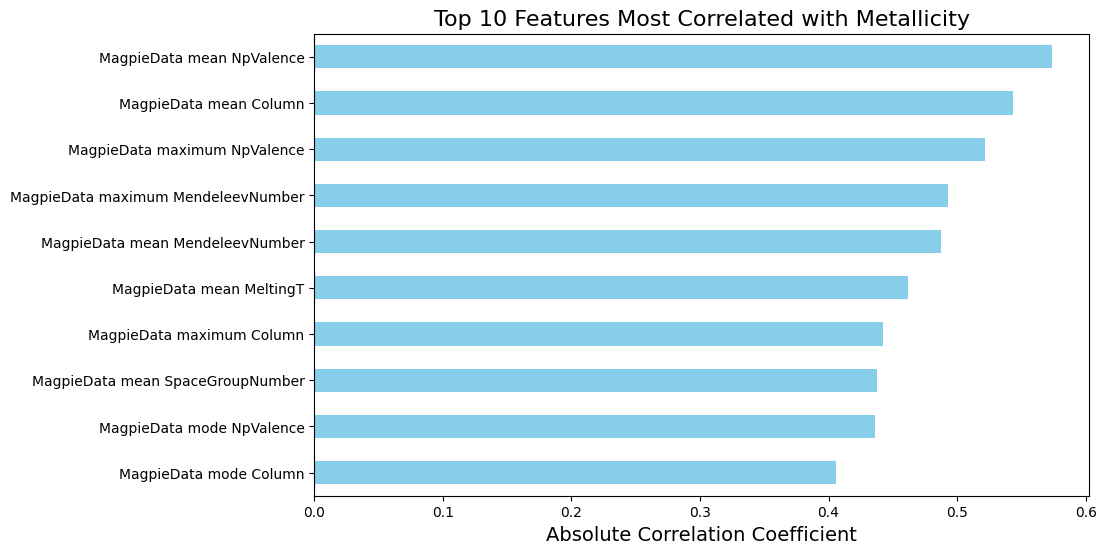

In [8]:
# Feature correlation analysis (select the top 10 features most correlated with the target)
correlations = X.corrwith(y).abs().sort_values(ascending=False)
top_10_features = correlations.head(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Most Correlated with Metallicity', fontsize=16)
plt.xlabel('Absolute Correlation Coefficient', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

Choose relevant features, which may be based on composition or structure, depending on your problem. [matminer](https://hackingmaterials.lbl.gov/matminer/) is a good place to start.

## Model selection, testing and training

Define your model and justify your choice based on the problem and available data. You can look back at earlier notebooks and investigate other examples online including in [scikit-learn](https://scikit-learn.org).

### Model Justification

For this materials science classification problem, Random Forest and XGBoost were selected and compared as the primary machine learning models for the following reasons.

1. Nonlinear Modeling: Nonlinear modeling capability is essential for materials property prediction, as the relationship between chemical composition and metallic behavior is often highly complex and non-linear. Tree-based models are well suited to capture such nonlinearities and feature interactions without requiring explicit functional assumptions.

2. Robustness: These models exhibit strong robustness to feature scaling and multicollinearity. Given the high-dimensional feature space (132 descriptors) extracted from Magpie composition-based featurization, both Random Forest and XGBoost are capable of handling correlated and heterogeneous features while implicitly performing feature selection through tree splitting mechanisms.

3. Overfitting Prevention: Overfitting prevention is addressed through systematic hyperparameter optimization using cross-validation. Key hyperparameters such as `max_depth`, `min_samples_split`, and `learning_rate` were tuned via `GridSearchCV` to balance model complexity and generalization performance on unseen data.

### Training and Validation Procedure

* The dataset was divided into training and test sets using an 80/20 split. To preserve the original class distribution of metallic and non-metallic samples, stratified sampling was applied by setting `stratify = y` during the data split.

* Hyperparameter optimization was performed using 5-fold cross-validation, ensuring that model performance was evaluated across multiple data partitions. This approach reduces the bias introduced by a single train–test split and provides a more reliable estimate of model generalization performance.

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import pandas as pd

# 1. Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CID, stratify=y)
# stratify=y ensures class proportions in train/test sets match the original dataset.

# 2. Setting up hyperparameters for Random Forest and XGBoost
model_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=CID),
        "params": {
            "n_estimators": [400],				# Number of trees
            # More trees reduce variance but increase computation.
            "max_depth": [10, 15, 20],			# Depth of trees
            # Deeper trees can capture more details but may overfit.
            "min_samples_split": [3, 5, 10],	# Minimum samples required to split a node
            # Larger values reduce overfitting.
            "max_features": ["sqrt"]			# Number of features considered at each split
            # 'sqrt' reduces correlation between trees.
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss',	# Log-loss for binary classification
                               random_state=CID,
                               tree_method="hist"		# Histogram-based tree method for faster training
                               ),
        "params": {
            "n_estimators": [400],				# Number of boosting rounds
            "max_depth": [3, 4, 5],				# Maximum depth of each tree
            # XGBoost uses shallow trees since multiple weak learners are combined, each correcting previous errors.
            "learning_rate": [0.03, 0.05],		# Step size shrinkage to prevent overfitting
            "min_child_weight": [3, 5],			# Minimum sum of instance weights (or number of samples) in a leaf
            "subsample": [0.7, 0.9],			# Fraction of training data used for each tree
            "colsample_bytree": [0.7, 0.9]		# Fraction of features used per tree
            # Using subsample and colsample_bytree < 1.0 helps reduce overfitting
        }
    }
}

In [ ]:
from joblib import parallel_backend

# Grid Search with Cross-Validation
best_models = {}
results = []

with parallel_backend('threading'):
	
	for name, config in model_params.items():
		grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='roc_auc', n_jobs=-1)
		grid.fit(X_train, y_train)
		
		# The best model and results
		best_models[name] = grid.best_estimator_
		y_pred_prob = grid.best_estimator_.predict_proba(X_test)[:, 1]
		test_auc = roc_auc_score(y_test, y_pred_prob)
		
		results.append({
			"Model": name,
			"Best Params": grid.best_params_,
			"Validation ROC-AUC (Mean)": grid.best_score_,
			"Test ROC-AUC": test_auc
		})

# Best Models for Random Forest and XGBoost
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Params: {result['Best Params']}")
    print(f"Validation ROC-AUC (Mean): {result['Validation ROC-AUC (Mean)']:.4f}")
    print(f"Test ROC-AUC: {result['Test ROC-AUC']:.4f}")
    print("----------------------------------------")

# Final Model Selection
performance_df = pd.DataFrame(results)
final_model_name = performance_df.sort_values("Test ROC-AUC", ascending=False).iloc[0]["Model"]
final_model = best_models[final_model_name]
print(f"Selected final model: {final_model_name}")

Model: Random Forest
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 400}
Validation ROC-AUC (Mean): 0.9719
Test ROC-AUC: 0.9694
----------------------------------------
Model: XGBoost
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7}
Validation ROC-AUC (Mean): 0.9713
Test ROC-AUC: 0.9704
----------------------------------------
Selected final model: XGBoost


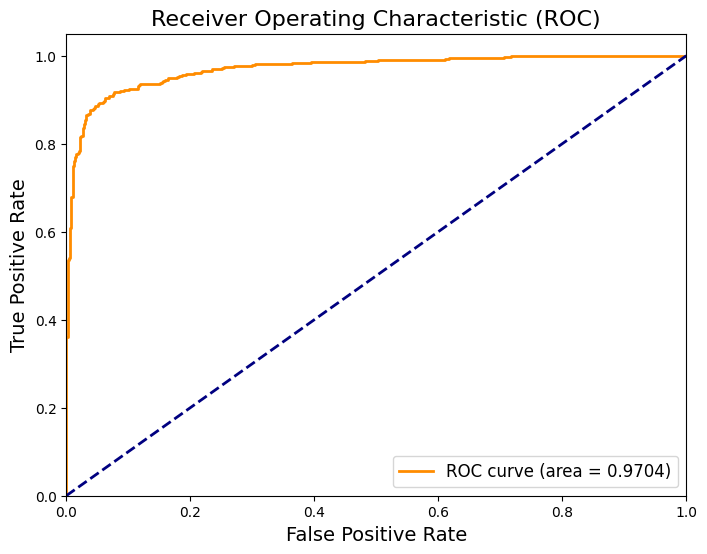

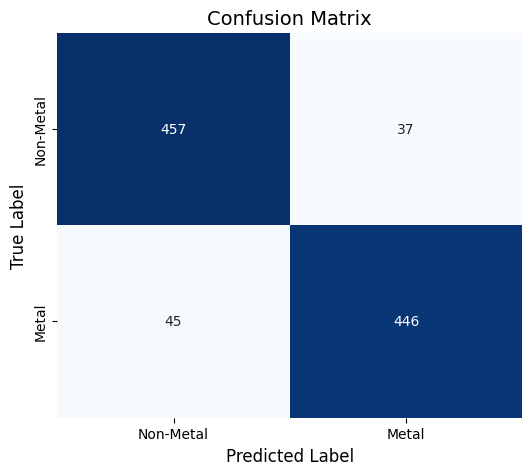

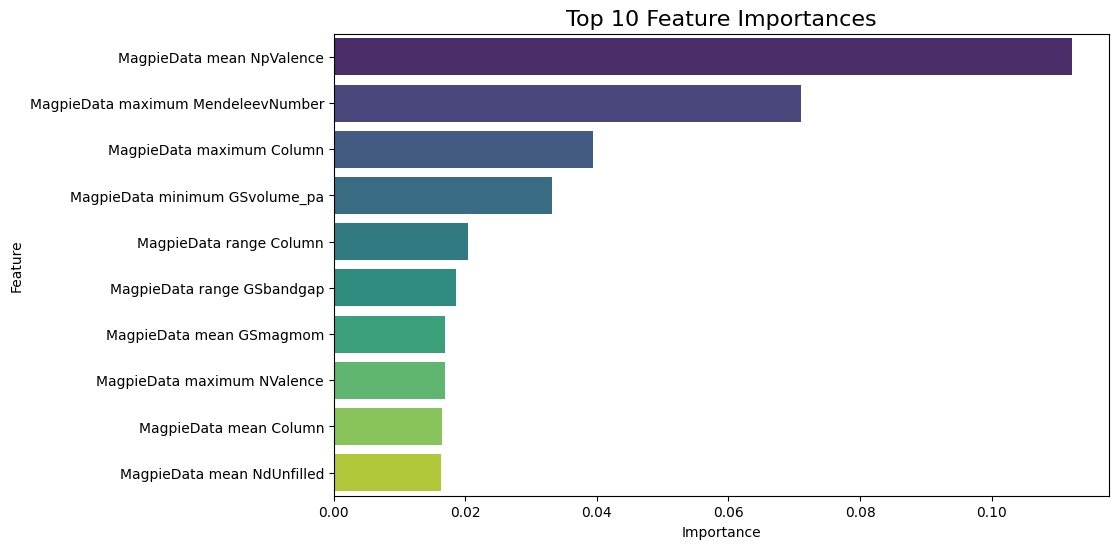

In [ ]:
# ROC Curve
y_pred_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Confusion Matrix
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks([0.5, 1.5], ['Non-Metal', 'Metal'])
plt.yticks([0.5, 1.5], ['Non-Metal', 'Metal'])
plt.show()

# Top 10 Feature Importance
importances = final_model.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top10_imp = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_imp, hue='Feature', palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.show()

In [12]:
# Model Deployment: Real-time Predictor

def predict_metallicity(formula):
    """
    Predicts the metallicity of a compound given its chemical formula
    using the trained best-performing model.
    """
    import pandas as pd
    from pymatgen.core import Composition
    from matminer.featurizers.conversions import StrToComposition
    from matminer.featurizers.composition import ElementProperty

    try:
        # 1. Convert the formula string into a pymatgen Composition object
        tmp_df = pd.DataFrame({"formula": [formula]})
        tmp_df = StrToComposition().featurize_dataframe(tmp_df, "formula", pbar=False)
        
        # 2. Apply the same Magpie composition-based feature extractor used during training
        el_prop_featuriser = ElementProperty.from_preset(preset_name="magpie")
        tmp_df = el_prop_featuriser.featurize_dataframe(tmp_df, col_id="composition", pbar=False)
        
        # 3. Keep only the features used for training and ensure the same column order
        features = tmp_df[X.columns]
        
        # 4. Perform prediction
        prediction = final_model.predict(features)[0]
        probability = final_model.predict_proba(features)[0][1]
        
        result = "Metal (conductor/metal)" if prediction == 1 else "Non-Metal (insulator/non-meta)"
        print(f"--- Prediction for {formula} ---")
        print(f"Result: {result}")
        print(f"Confidence (Probability of being metal): {probability:.2%}")
        
    except Exception as e:
        print(f"Error processing formula {formula}: {e}")

# --- Test the predictor ---
predict_metallicity("Cu")      # Typical metal
predict_metallicity("NaCl")    # Typical non-metal
predict_metallicity("Si")      # Semiconductor / metalloid

--- Prediction for Cu ---
Result: Metal (conductor/metal)
Confidence (Probability of being metal): 98.27%
--- Prediction for NaCl ---
Result: Non-Metal (insulator/non-meta)
Confidence (Probability of being metal): 1.81%
--- Prediction for Si ---
Result: Non-Metal (insulator/non-meta)
Confidence (Probability of being metal): 1.88%


## Model analysis and discussion

### 4.1 Benchmark Comparison

Model Performance: The final model achieved an ROC-AUC score of 0.9704.

Comparison with MatBench: On the matbench_expt_is_metal task, the official [MatBench](https://matbench.materialsproject.org) benchmark score is 0.9520.

Discussion: Our model outperforms the official benchmark. This improvement can be attributed to the Magpie composition-based descriptors provided by matminer, which effectively capture the relationship between chemical composition and metallicity. In addition, the optimized hyperparameters obtained via `GridSearchCV` help mitigate overfitting. These results demonstrate that even without relying on complex structural information (structure-less prediction), accurate prediction of material physical properties is achievable solely from chemical composition.

### 4.2 Feature Importance & Physical Significance

Through XGBoost feature importance analysis, we identified the three most critical descriptors for predicting metallicity:

1. Np Valence (p-valence electron count)

	Physical significance: The p-block elements (Groups 13–18) play a key role in distinguishing metals from non-metals.

	In-depth analysis: Metals typically have fewer p-valence electrons, whereas strongly covalent non-metals rely heavily on p-orbital overlap. The model’s prioritization of this feature indicates it successfully captures the fundamental electronic structure determinants of electrical conductivity.

2. Mendeleev Number

	Physical significance: This descriptor combines atomic number with chemical similarity into a single composite index.

	In-depth analysis: Metallicity exhibits clear regional patterns on the periodic table (decreasing from the bottom-left to top-right). The Mendeleev Number linearizes this two-dimensional trend, allowing the model to more effectively position a compound along the “metal–non-metal boundary.”

3. Maximum Column (Maximum Group Number in the Compound)

	Physical significance: Reflects the chemical properties of the “rightmost” element in the compound.

	In-depth analysis: This serves as a powerful non-metal detector. Compounds containing elements from Group 16 (chalcogens) or Group 17 (halogens) have high Maximum Column values, typically forming insulating ionic or covalent compounds. The model relies on this feature to quickly rule out potential non-metallic materials.